In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
match_data = pd.read_excel("match_data.xlsx")

In [23]:
match_data = match_data[~(match_data['suspended'] | match_data['stopped'])]
match_data.reset_index(inplace=True, drop= True)
indices = match_data.index[(match_data['Score Change - away'] == -1) | (match_data['Score Change - home'] == -1)]
rows_to_drop = set(indices) | set(indices - 1)
rows_to_drop = [i for i in rows_to_drop if i >= 0]
match_data = match_data.drop(index=rows_to_drop)
match_data.reset_index(inplace=True, drop= True)
match_data.loc[match_data['halftime'] == '2nd-half', 'minute'] += 45
match_data = match_data.drop_duplicates(subset=['fixture_id', 'minute'], keep='last')
match_data.rename(columns={1:'1', 2:'2'}, inplace=True)
match_data['current_state'] = match_data['current_state'].map({'1': 1, 'X': 0, '2': 2})
match_data = match_data.fillna(0)



In [24]:
match_data['difference_passes'] = match_data['Passes - away'] - match_data['Passes - home']
match_data['difference_shots'] = match_data['Shots Total - away'] - match_data['Shots Total - home']
match_data['difference_shots_on_target'] = match_data['Shots On Target - away'] - match_data['Shots On Target - home']
match_data['difference_goal_kicks'] = match_data['Goal Kicks - away'] - match_data['Goal Kicks - home']
match_data['difference_goal_attempts'] = match_data['Goal Attempts - away'] - match_data['Goal Attempts - home']
match_data['difference_counter_attacks'] = match_data['Counter Attacks - away'] - match_data['Counter Attacks - home']
match_data['difference_attacks'] = match_data['Attacks - away'] - match_data['Attacks - home']
match_data['difference_ball_possession'] = match_data['Ball Possession % - away'] - match_data['Ball Possession % - home']
match_data['difference_dangerous_attacks'] = match_data['Dangerous Attacks - away'] - match_data['Dangerous Attacks - home']
match_data['difference_successful_passes'] = match_data['Successful Passes - away'] - match_data['Successful Passes - home']


In [25]:
# Define the test set start date as per project requirements
test_set_start_date = "2024-11-01"

# Ensure match_start_datetime is available and properly formatted
if "match_start_datetime" in match_data.columns:
    # Filter training and test data based on the date
    training_data = match_data[
        match_data["match_start_datetime"] < test_set_start_date
    ]
    test_data = match_data[
        match_data["match_start_datetime"] >= test_set_start_date
    ]

# Check the sizes of the training and test sets
training_data_size = training_data.shape[0]
test_data_size = test_data.shape[0]

training_data_size, test_data_size

(44520, 9522)

In [26]:
def normalization(data):    
    #data = data[['fixture_id','halftime', 'minute', 'second','1','2','X','result']]
    data = data.copy()
    data['P_home'] = 1 / data['1']
    data['P_draw'] = 1 / data['X']
    data['P_away'] = 1 / data['2']

    data['P_sum'] = data['P_home'] + data['P_draw'] + data['P_away']
    data['normalized_P_home'] = data['P_home'] / data['P_sum']
    data['normalized_P_draw'] = data['P_draw'] / data['P_sum']
    data['normalized_P_away'] = data['P_away'] / data['P_sum']

    return data

In [27]:
training_data = normalization(training_data)
test_data = normalization(test_data)

In [28]:
features = [
    "current_state",
    "difference_passes",
    "difference_shots",
    "difference_shots_on_target",
    "difference_goal_kicks",
    "difference_counter_attacks",
    "difference_attacks",
    "difference_ball_possession",
    "difference_dangerous_attacks",
    "difference_successful_passes",
    "normalized_P_home",
    "normalized_P_away",
    "normalized_P_draw"
]


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [30]:
def make_sequential_predictions(X_test, test_data, dt_model, confidence_threshold=0.8):
    # Get probability predictions
    probabilities = dt_model.predict_proba(X_test)
    
    # Create a DataFrame with predictions and match information
    pred_df = pd.DataFrame({
        'fixture_id': test_data['fixture_id'],
        'minute': test_data['minute'],
        'halftime': test_data['halftime'],
        'max_prob': np.max(probabilities, axis=1),
        'predicted_outcome': np.argmax(probabilities, axis=1),
        'prob_draw': probabilities[:, 0],
        'prob_home': probabilities[:, 1],
        'prob_away': probabilities[:, 2],
        'actual_result': test_data['result']
    })
    
    # Sort by match_id and minute to ensure chronological order
    # pred_df = pred_df.sort_values(['fixture_id', 'minute'])
    
    # Get first prediction above threshold for each match
    first_predictions = pred_df[pred_df['max_prob'] >= confidence_threshold].groupby('fixture_id').first().reset_index()
    
    return first_predictions



In [31]:
def calculate_betting_results(predictions, match_data, bet_amount=100):
    # Create a copy of predictions
    results = predictions.copy()
    
    # Merge predictions with match_data to get odds
    results = results.merge(
        match_data[['fixture_id', 'minute', '1', 'X', '2']], 
        on=['fixture_id', 'minute'], 
        how='left'
    )
    
    results['actual_result'] = results['actual_result'].map({'X': 0, '1': 1, '2': 2})

    # Initialize columns for bet calculations
    results['bet_amount'] = bet_amount
    results['bet_odds'] = 0.0
    results['profit'] = 0.0
    
    # Get odds for each prediction
    for idx, row in results.iterrows():
        if row['predicted_outcome'] == 1:  # Home win prediction
            results.loc[idx, 'bet_odds'] = row['1']  # Use home win odds
        elif row['predicted_outcome'] == 0:  # Draw prediction
            results.loc[idx, 'bet_odds'] = row['X']  # Use draw odds
        else:  # Away win prediction
            results.loc[idx, 'bet_odds'] = row['2']  # Use away win odds
    
    # Calculate profit/loss
    results['profit'] = np.where(
        results['predicted_outcome'] == results['actual_result'],
        (results['bet_odds'] * results['bet_amount']) - results['bet_amount'],  # Win: (odds * bet) - bet
        -results['bet_amount']  # Loss: -bet
    )
    
    # Calculate summary statistics
    total_bets = len(results)
    winning_bets = sum(results['predicted_outcome'] == results['actual_result'])
    total_profit = results['profit'].sum()
    roi = (total_profit / (total_bets * bet_amount)) * 100
    
    return results


In [34]:
def test_model_configurations(training_data, test_data, features, bet_amount=100):
    # Configuration parameters
    time_periods = [(15, 90), (30, 90), (45, 90)]
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    max_depths = [5, 8, 10, 12, 15]  # Added different max_depth values
    
    results = []
    
    for min_minute, max_minute in time_periods:
        for max_depth in max_depths:  # Added max_depth loop
            # Filter and prepare data as before...
            train_period = training_data[training_data['minute'] > min_minute].copy()
            test_period = test_data[test_data['minute'] > min_minute].copy()
            
            X_train = train_period[features]
            X_test = test_period[features]
            Y_train = train_period['result'].map({'1': 1, 'X': 0, '2': 2})
            
            # Use current max_depth
            dt_model = DecisionTreeClassifier(
                criterion='gini', 
                max_depth=max_depth, 
                random_state=42
            )
            dt_model.fit(X_train, Y_train)
            
            # Test different thresholds
            for threshold in thresholds:
                # Get predictions
                first_predictions = make_sequential_predictions(
                    X_test, 
                    test_period, 
                    dt_model, 
                    confidence_threshold=threshold
                )
                
                # Calculate betting results
                betting_results = calculate_betting_results(
                    first_predictions, 
                    test_period, 
                    bet_amount=bet_amount
                )
                
                # Store configuration results
                config_result = {
                    'min_minute': min_minute,
                    'max_depth': max_depth,  # Added to results
                    'threshold': threshold,
                    'total_bets': len(betting_results),
                    'win_rate': (betting_results['predicted_outcome'] == betting_results['actual_result']).mean() * 100,
                    'total_profit': betting_results['profit'].sum(),
                    'roi': (betting_results['profit'].sum() / (len(betting_results) * bet_amount)) * 100
                }
                results.append(config_result)
    
    # Convert results to DataFrame, sort by ROI, and round numeric columns
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('roi', ascending=False)
    
    # Round numeric columns for cleaner display
    results_df['win_rate'] = results_df['win_rate'].round(2)
    results_df['total_profit'] = results_df['total_profit'].round(2)
    results_df['roi'] = results_df['roi'].round(2)
    results_df.reset_index(drop=True, inplace=True)
    print("\nModel Configuration Results (sorted by ROI):")
    
    return results_df

# Run the analysis
results = test_model_configurations(training_data, test_data, features)
results


Model Configuration Results (sorted by ROI):


,min_minute,max_depth,threshold,total_bets,win_rate,total_profit,roi
0,15,8,0.9,98,83.67,1150.0,11.73
1,15,10,0.5,111,55.86,1186.0,10.68
2,15,12,0.7,111,52.25,415.0,3.74
3,15,10,0.6,111,56.76,354.0,3.19
4,15,5,0.9,88,92.05,251.0,2.85
...,...,...,...,...,...,...,...
70,30,15,0.7,111,43.24,-2368.0,-21.33
71,30,15,0.6,111,42.34,-2548.0,-22.95
72,45,12,0.5,111,51.35,-2735.0,-24.64
73,45,12,0.9,111,54.95,-2791.0,-25.14



Model Configuration Results (sorted by ROI):

Detailed Analysis of Top 1 Models:
--------------------------------------------------

Model 1
Configuration:
- Minimum Minute: 15.0
- Max Depth: 8.0
- Threshold: 0.9

Performance Metrics:
- ROI: 11.73%
- Total Bets: 98.0
- Win Rate: 83.67%
- Total Profit: 1150.00

Confusion Matrix:
[[ 6  4  4]
 [ 3 51  0]
 [ 1  4 25]]

Detailed Classification Report:
              precision    recall  f1-score   support

        Draw       0.60      0.43      0.50        14
        Home       0.86      0.94      0.90        54
        Away       0.86      0.83      0.85        30

    accuracy                           0.84        98
   macro avg       0.78      0.74      0.75        98
weighted avg       0.83      0.84      0.83        98


Betting Time Analysis:
- Average Minute: 59.5
- Median Minute: 61.5
- Earliest Bet: 16.0
- Latest Bet: 102.0


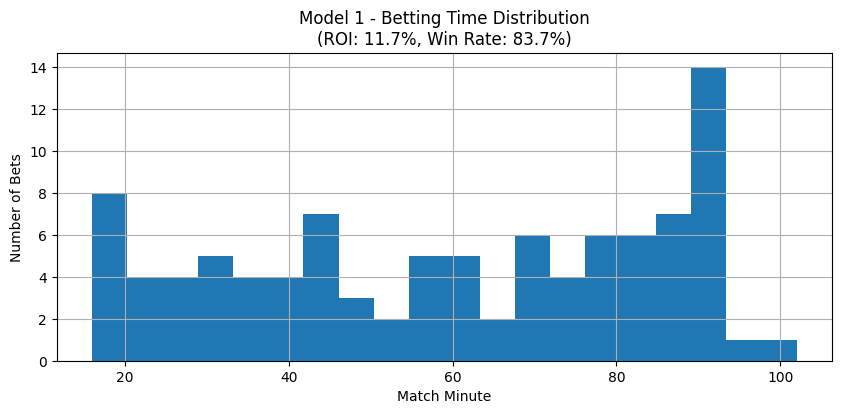


Feature Importance Ranking:
                         feature  importance
10             normalized_P_home    0.493789
12             normalized_P_draw    0.253893
6             difference_attacks    0.041668
11             normalized_P_away    0.033322
4          difference_goal_kicks    0.027670
8   difference_dangerous_attacks    0.025727
7     difference_ball_possession    0.024326
9   difference_successful_passes    0.024116
5     difference_counter_attacks    0.021248
3     difference_shots_on_target    0.020871
2               difference_shots    0.020215
1              difference_passes    0.011006
0                  current_state    0.002149




In [39]:
def analyze_best_models(training_data, test_data, features, top_n=3):
    """
    Performs detailed analysis of the best performing models.
    
    Parameters:
    -----------
    training_data : DataFrame
        Training dataset
    test_data : DataFrame
        Test dataset
    features : list
        Features to be used
    top_n : int
        Number of top models to analyze
    """
    
    # First, test all models and find the best ones
    results_df = test_model_configurations(training_data, test_data, features)
    top_models = results_df.head(top_n)
    
    print(f"\nDetailed Analysis of Top {top_n} Models:")
    print("-" * 50)
    
    for idx, model in top_models.iterrows():
        print(f"\nModel {idx+1}")
        print("=" * 30)
        print(f"Configuration:")
        print(f"- Minimum Minute: {model['min_minute']}")
        print(f"- Max Depth: {model['max_depth']}")
        print(f"- Threshold: {model['threshold']}")
        print(f"\nPerformance Metrics:")
        print(f"- ROI: {model['roi']:.2f}%")
        print(f"- Total Bets: {model['total_bets']}")
        print(f"- Win Rate: {model['win_rate']:.2f}%")
        print(f"- Total Profit: {model['total_profit']:.2f}")
        
        # Recreate and analyze the model with this configuration
        train_period = training_data[training_data['minute'] > model['min_minute']].copy()
        test_period = test_data[test_data['minute'] > model['min_minute']].copy()
        
        X_train = train_period[features]
        X_test = test_period[features]
        Y_train = train_period['result'].map({'1': 1, 'X': 0, '2': 2})
        Y_test = test_period['result'].map({'1': 1, 'X': 0, '2': 2})
        
        dt_model = DecisionTreeClassifier(
            criterion='gini', 
            max_depth=int(model['max_depth']), 
            random_state=42
        )
        dt_model.fit(X_train, Y_train)
        
        # Get predictions
        first_predictions = make_sequential_predictions(
            X_test, 
            test_period, 
            dt_model, 
            confidence_threshold=model['threshold']
        )
        
        # Confusion Matrix and Classification Report
        y_pred = first_predictions['predicted_outcome']
        y_true = first_predictions['actual_result'].map({'1': 1, 'X': 0, '2': 2})
        
        print("\nConfusion Matrix:")
        conf_matrix = confusion_matrix(y_true, y_pred)
        print(conf_matrix)
        
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, 
                                 target_names=['Draw', 'Home', 'Away']))
        
        # Betting time analysis
        print("\nBetting Time Analysis:")
        minute_stats = first_predictions['minute'].describe()
        print(f"- Average Minute: {minute_stats['mean']:.1f}")
        print(f"- Median Minute: {minute_stats['50%']:.1f}")
        print(f"- Earliest Bet: {minute_stats['min']:.1f}")
        print(f"- Latest Bet: {minute_stats['max']:.1f}")
        
        # Visualize betting time distribution
        plt.figure(figsize=(10, 4))
        plt.hist(first_predictions['minute'], bins=20)
        plt.title(f'Model {idx+1} - Betting Time Distribution\n' +
                 f'(ROI: {model["roi"]:.1f}%, Win Rate: {model["win_rate"]:.1f}%)')
        plt.xlabel('Match Minute')
        plt.ylabel('Number of Bets')
        plt.grid(True)
        plt.show()
        
        # Feature importance analysis
        importance = pd.DataFrame({
            'feature': features,
            'importance': dt_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nFeature Importance Ranking:")
        print(importance)
        
        print("\n" + "="*50 + "\n")

# Call the function
analyze_best_models(training_data, test_data, features, top_n=1)